In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Analysis: CO2 Transformer Analysis & Reporting

1. Data exploration
2. Model performance (load benchmark results)
3. Attention visualization
4. Feature importance (gradient-based)
5. Root cause analysis (physical interpretation)
6. Error analysis
7. Comparison with original DAE-LSTM, kinetic model, fused, and SSAE results

In [78]:
import os, sys, math
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
from sklearn.metrics import mean_squared_error

sys.path.insert(0, os.path.abspath('..'))
from src.data_pipeline import prepare_data, create_dataloaders, load_excel_files
from src.model import CO2Transformer
from src.utils import seed_everything, get_device, rmse, load_scalers

model_dir = os.path.join('..', 'saved_models')
results_dir = os.path.join('..', 'results')
paper_results_dir = os.path.join('..', '..', 'results') # paper results

device = get_device()
seed_everything(42)
print(f'Device: {device}')

Device: cpu


In [5]:
# Load data
train_dfs, test_dfs, general_scaler, conc_scaler, feature_names = prepare_data()
print(f'Train files: {len(train_dfs)}, Test files: {len(test_dfs)}')
print(f'Features: {len(feature_names)}')

Train files: 7, Test files: 1
Features: 90


In [62]:
# Group 90 sensor features by type based on prefix convention
# TT=Temperature, FT=Flow, PT/PDT=Pressure, LT=Level, AT(pH)=pH, AT(CO2)=Analyzer
sensor_types = {
    'Temperature': [f for f in feature_names if f.startswith('TT')],
    'Flow':        [f for f in feature_names if f.startswith('FT')],
    'Pressure':    [f for f in feature_names if f.startswith('PT') or f.startswith('PDT')],
    'Level':       [f for f in feature_names if f.startswith('LT')],
    'pH':          [f for f in feature_names if 'pH' in f],
    'Analyzer':    [f for f in feature_names if f.startswith('AT') and 'CO2' in f],
}

for stype, cols in sensor_types.items():
    print(f'  {stype:12s}: {len(cols)} sensors')
print(f'  Total: {sum(len(v) for v in sensor_types.values())}')

  Temperature : 53 sensors
  Flow        : 19 sensors
  Pressure    : 11 sensors
  Level       : 4 sensors
  pH          : 2 sensors
  Analyzer    : 1 sensors
  Total: 90



## 1. Data Exploration

In [ ]:
# Load raw data for exploration
df_list_raw, paths_raw = load_excel_files()
for df in df_list_raw:
    df.set_index('time', inplace=True)

print('Dataset overview:')
for i, (df, path) in enumerate(zip(df_list_raw, paths_raw)):
    name = os.path.basename(path)
    labels = df['label'].value_counts().sort_index()
    label_str = ', '.join(f'Point_{int(k)}: {v}' for k, v in labels.items())
    print(f'  {name}: {df.shape[0]} rows, labels [{label_str}]')

Dataset overview:
  140120_1.xlsx: 117 rows, labels [Point_1: 21, Point_2: 21, Point_3: 21, Point_4: 14, Point_5: 19, Point_6: 21]
  140206_1.xlsx: 50 rows, labels [Point_1: 9, Point_2: 9, Point_3: 9, Point_4: 6, Point_5: 9, Point_6: 8]
  140207_1.xlsx: 118 rows, labels [Point_1: 21, Point_2: 21, Point_3: 21, Point_4: 15, Point_5: 19, Point_6: 21]
  140207_2.xlsx: 50 rows, labels [Point_1: 9, Point_2: 9, Point_3: 9, Point_4: 6, Point_5: 8, Point_6: 9]
  140214_1.xlsx: 67 rows, labels [Point_1: 12, Point_2: 12, Point_3: 12, Point_4: 8, Point_5: 11, Point_6: 12]
  140214_2.xlsx: 50 rows, labels [Point_1: 9, Point_2: 8, Point_3: 9, Point_4: 6, Point_5: 9, Point_6: 9]
  140227_1.xlsx: 218 rows, labels [Point_1: 39, Point_2: 39, Point_3: 39, Point_4: 28, Point_5: 34, Point_6: 39]
  140313_1.xlsx: 228 rows, labels [Point_1: 39, Point_2: 39, Point_3: 39, Point_4: 26, Point_5: 35, Point_6: 50]


## 2. Model Performance

Load benchmark results from `train_and_evaluate.ipynb`.

In [7]:
# Load benchmark results
results_path = os.path.join(results_dir, 'benchmark_results.csv')
if os.path.exists(results_path):
    df_results = pd.read_csv(results_path)
    print('Benchmark results loaded.')
    display_cols = ['input_window', 'forecast_window', 'overall_rmse',
                    'Point 1', 'Point 2', 'Point 3', 'Point 4', 'Point 5', 'Point 6']
    print(df_results[display_cols].to_string(index=False, float_format='%.4f'))
else:
    print('No benchmark_results.csv found. Run train_and_evaluate.ipynb first.')
    df_results = None

Benchmark results loaded.
 input_window  forecast_window  overall_rmse  Point 1  Point 2  Point 3  Point 4  Point 5  Point 6
           15                1        0.1731   0.0040   0.0038   0.0282   0.0401   0.1587   0.3902
           15                4        0.1927   0.0023   0.0038   0.0337   0.0466   0.1806   0.4321
           15                8        0.1886   0.0016   0.0016   0.0351   0.0503   0.1718   0.4245
           15               18        0.1778   0.0016   0.0016   0.0350   0.0501   0.1406   0.4077
           17                1        0.1640   0.0035   0.0033   0.0293   0.0378   0.1357   0.3751
           17                4        0.1890   0.0013   0.0023   0.0347   0.0475   0.2156   0.4055
           17                8        0.1894   0.0031   0.0026   0.0328   0.0460   0.1855   0.4215
           17               18        0.1765   0.0014   0.0015   0.0347   0.0511   0.1343   0.4063
           19                1        0.1842   0.0034   0.0032   0.0281   0.0373   

/tmp/ipython-input-2561767665.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10').colors # Using a matplotlib colormap for distinct colors


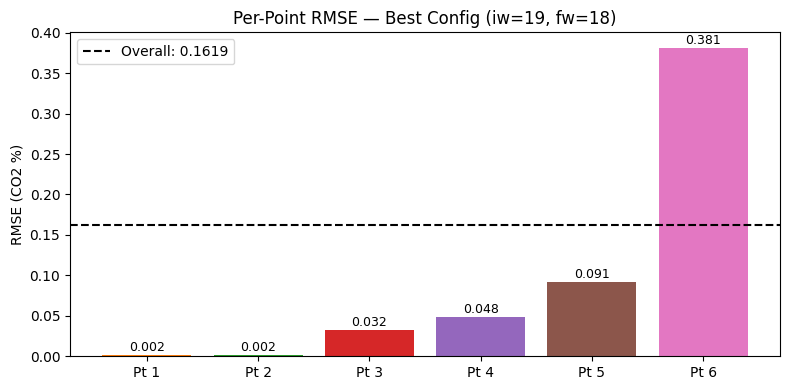

In [14]:
# Per-point RMSE bar chart for best configuration
if df_results is not None:
    best = df_results.loc[df_results['overall_rmse'].idxmin()]
    best_iw = int(best['input_window'])
    best_fw = int(best['forecast_window'])

    fig, ax = plt.subplots(figsize=(8, 4))
    points = [f'Pt {i}' for i in range(1, 7)]
    rmses = [best[f'Point {i}'] for i in range(1, 7)]
    # Define colors for the bar chart
    colors = plt.cm.get_cmap('tab10').colors # Using a matplotlib colormap for distinct colors
    bars = ax.bar(points, rmses, color=colors[1:7])
    ax.axhline(y=best['overall_rmse'], color='black', linestyle='--', label=f'Overall: {best["overall_rmse"]:.4f}')
    ax.set_ylabel('RMSE (CO2 %)')
    ax.set_title(f'Per-Point RMSE — Best Config (iw={best_iw}, fw={best_fw})')
    ax.legend()
    for bar, val in zip(bars, rmses):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{val:.3f}', ha='center', fontsize=9)
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, 'per_point_rmse.png'), dpi=150)
    plt.show()

In [17]:
df_results[df_results['input_window'] == 15]

,input_window,forecast_window,overall_rmse,epochs,best_val_loss,time_sec,Point 1,Point 2,Point 3,Point 4,Point 5,Point 6
0,15,1,0.173127,247,0.000111,65.464751,0.003968,0.003823,0.028239,0.040112,0.158666,0.390161
1,15,4,0.192651,318,0.000091,84.603766,0.002301,0.003848,0.033685,0.046593,0.180638,0.432123
2,15,8,0.188619,401,0.000077,98.593317,0.001618,0.001579,0.035107,0.050342,0.171814,0.424465
3,15,18,0.177825,432,0.000096,95.855189,0.001560,0.001559,0.034965,0.050071,0.140610,0.407708


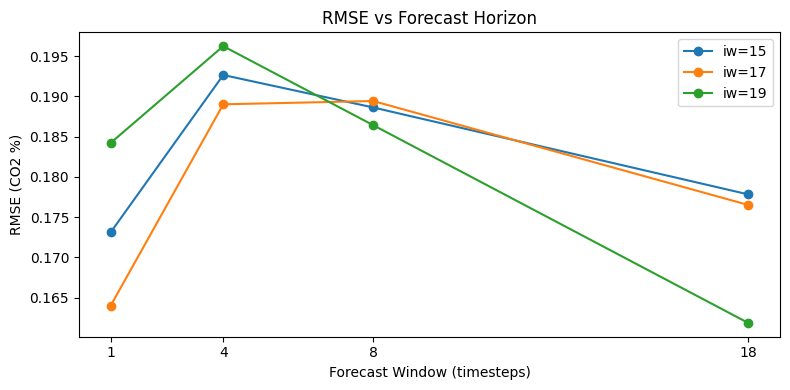

In [16]:
# RMSE vs forecasting
if df_results is not None:
    fig, ax = plt.subplots(figsize=(8, 4))
    for iw in df_results['input_window'].unique():
        subset = df_results[df_results['input_window'] == iw]
        ax.plot(subset['forecast_window'], subset['overall_rmse'],
                'o-', label=f'iw={iw}', markersize=6)
    ax.set_xlabel('Forecast Window (timesteps)')
    ax.set_ylabel('RMSE (CO2 %)')
    ax.set_title('RMSE vs Forecast Horizon')
    ax.legend()
    ax.set_xticks([1, 4, 8, 18])
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, 'rmse_vs_horizon.png'), dpi=150)
    plt.show()

## 3. Attention Visualization

Extract attention weights from each head/layer to see which past timesteps the model attends to.

In [18]:
# Load best model
if df_results is not None:
    best_iw = int(df_results.loc[df_results['overall_rmse'].idxmin(), 'input_window'])
    best_fw = int(df_results.loc[df_results['overall_rmse'].idxmin(), 'forecast_window'])
else:
    best_iw, best_fw = 17, 1  # default

model = CO2Transformer(forecast_window=best_fw).to(device)
save_path = os.path.join(model_dir, f'model_iw{best_iw}_fw{best_fw}.pt')
if os.path.exists(save_path):
    state = torch.load(save_path, map_location=device, weights_only=True)
    model.load_state_dict(state)
    print(f'Loaded model: inputWindow={best_iw}, forecastWindoww={best_fw}')
else:
    print(f'Saved model not found: {save_path}')
    print('Using random weights for demonstration.')

model.eval()

# Get test data
_, _, test_loader = create_dataloaders(
    train_dfs, test_dfs, feature_names,
    input_window=best_iw, forecast_window=best_fw, batch_size=32
)
x_batch, y_batch = next(iter(test_loader))
x_batch = x_batch.to(device)

with torch.no_grad():
    pred = model(x_batch)
    attn_weights = model.get_attention_weights()

Loaded model: inputWindow=19, forecastWindoww=18


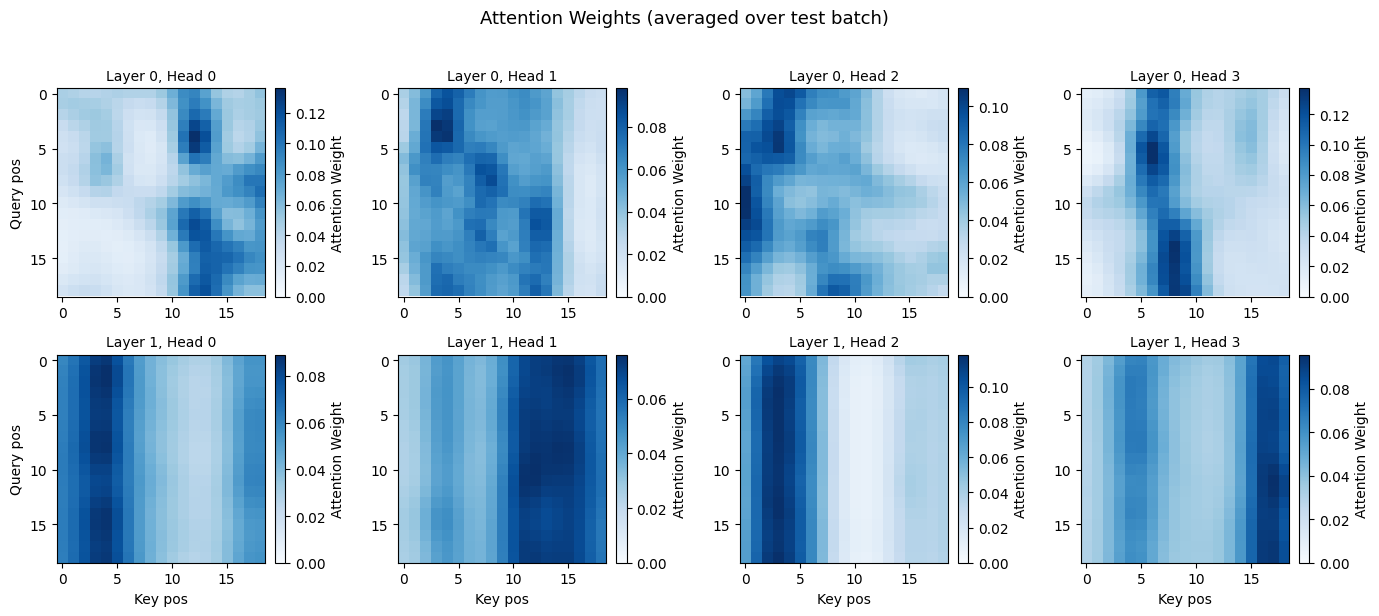

In [44]:
# Attention heatmaps — all heads, all layers
n_layers = len(attn_weights) # 2 layers
n_heads = attn_weights[0].shape[1] # 4 heads

fig, axes = plt.subplots(n_layers, n_heads, figsize=(3.5 * n_heads, 3 * n_layers))
if n_layers == 1:
    axes = axes.reshape(1, -1)

# Average over batch
for layer in range(n_layers):
    attn = attn_weights[layer].cpu().numpy().mean(axis=0)  # (heads, seq=19, seq)
    for head in range(n_heads):
        ax = axes[layer, head]
        im = ax.imshow(attn[head], cmap='Blues', vmin=0)
        ax.set_title(f'Layer {layer}, Head {head}', fontsize=10)
        if head == 0:
            ax.set_ylabel('Query pos')
        if layer == n_layers - 1:
            ax.set_xlabel('Key pos')
        # Add colorbar for each head's attention map
        plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, label='Attention Weight')

fig.suptitle('Attention Weights (averaged over test batch)', fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'attention_heatmaps.png'), dpi=150, bbox_inches='tight')
plt.show()

1.   Darker blue indicating higher attention weight, meaning the model is focusing more on that darker key positions when computing the representation for that query position.
2.   Layer 1 heads seem to attend to specific history lengths. For example, Head 0 attends mainly to early timesteps, and Head 3 the most recent steps. Allocating high attentions to specific and localized temporal relatioships.
3. Layer 0 heads show interests in wider regions, suggesting that they are likely capturing more general dependencies across the input sequence. The variations across heads indicating each head learnt different types of temporal patterns.

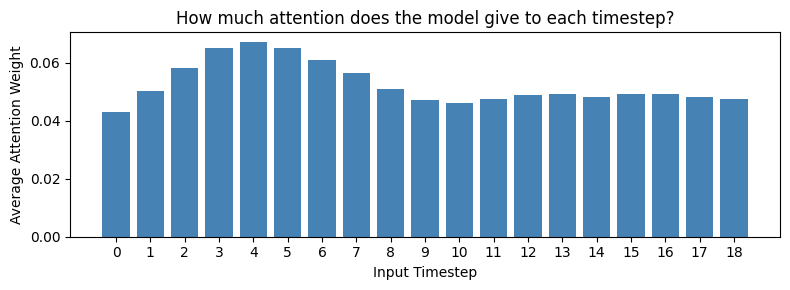

Peak attention at timestep 4


In [55]:
# Attention over time
# Average attention received by each key position (across all queries, heads, layers)

all_attn = torch.stack(attn_weights).cpu().numpy()  # (layers, batch, heads, Q_seq, K_seq)
avg_attn = all_attn.mean(axis=(0, 1, 2, 3))  # (seq,)

fig, ax = plt.subplots(figsize=(8, 3))
ax.bar(range(best_iw), avg_attn, color='steelblue')
ax.set_xlabel('Input Timestep')
ax.set_ylabel('Average Attention Weight')
ax.set_title('How much attention does the model give to each timestep?')
ax.set_xticks(range(best_iw))
ax.set_xticklabels(range(best_iw))
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'attention_temporal.png'), dpi=150)
plt.show()

peak = np.argmax(avg_attn)
print(f'Peak attention at timestep {peak}')

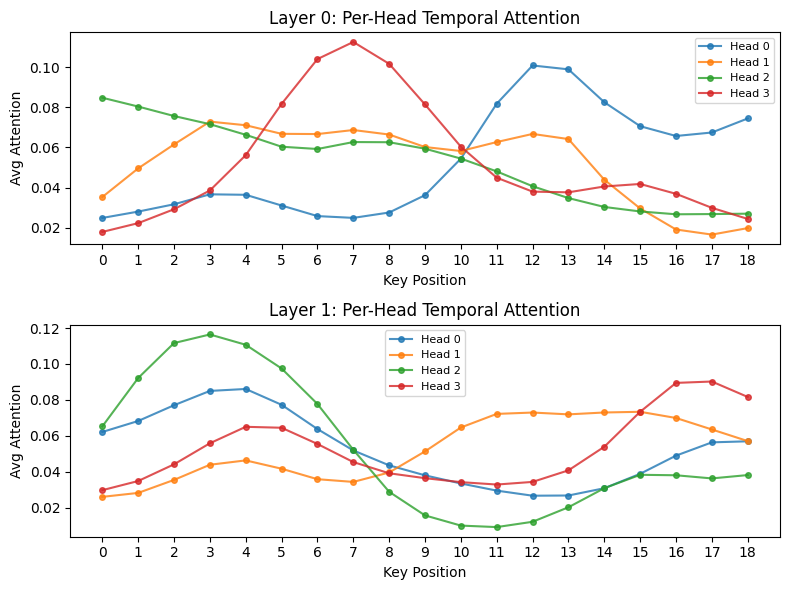

In [57]:
# Per-head attention patterns
#n_layers = len(attn_weights)
fig, axes = plt.subplots(n_layers, 1, figsize=(8, 3 * n_layers))
if n_layers == 1:
    axes = [axes]

for layer in range(n_layers):
    ax = axes[layer]
    attn = attn_weights[layer].cpu().numpy().mean(axis=(0, 2))  # (heads, seq) avg over batch & queries
    for h in range(n_heads):
        ax.plot(attn[h], label=f'Head {h}', alpha=0.8, marker='o', markersize=4) # Added marker='o' and markersize
    ax.set_xlabel('Key Position')
    ax.set_ylabel('Avg Attention')
    ax.set_title(f'Layer {layer}: Per-Head Temporal Attention')
    ax.set_xticks(range(best_iw)) # Set explicit x-ticks
    ax.set_xticklabels(range(best_iw)) # Label x-ticks with numbers
    ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'attention_per_head.png'), dpi=150)
plt.show()

---
## 4. Feature Importance

Compute input gradient magnitude averaged over test samples. This shows which of the 90 sensor features + 6 one-hot labels contribute most to predictions.

In [58]:
# Gradient-based feature importance
model.eval()
all_grads = []

for x_b, y_b in test_loader:
    x_b = x_b.to(device).requires_grad_(True)
    y_b = y_b.to(device)
    pred = model(x_b)
    loss = F.mse_loss(pred, y_b)
    loss.backward()
    # Gradient magnitude per feature (avg over time and batch)
    grad = x_b.grad.abs().cpu().numpy()  # (batch, seq, 96)
    all_grads.append(grad.mean(axis=(0, 1)))  # (96,)

avg_grad = np.mean(all_grads, axis=0)  # (96,)

# Split into sensor features (90) and one-hot (6)
sensor_importance = avg_grad[:90]
onehot_importance = avg_grad[90:]

print(f'Sensor features gradient importance: shape {sensor_importance.shape}')
print(f'One-hot label gradient importance:   shape {onehot_importance.shape}')

Sensor features gradient importance: shape (90,)
One-hot label gradient importance:   shape (6,)


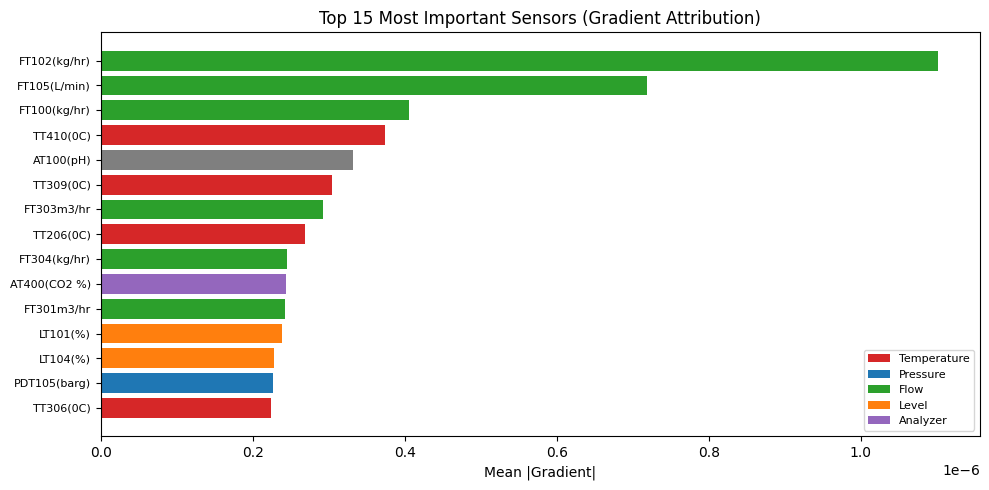

In [63]:
# Top 20 most important sensor features
sorted_idx = np.argsort(sensor_importance)[::-1]
top_n = 15
fig, ax = plt.subplots(figsize=(10, 5))
top_names = [feature_names[i] for i in sorted_idx[:top_n]]
top_vals = sensor_importance[sorted_idx[:top_n]]

# Color by sensor type
type_colors = {'Temperature': 'tab:red', 'Pressure': 'tab:blue',
               'Flow': 'tab:green', 'Level': 'tab:orange', 'Analyzer': 'tab:purple',
               'Other': 'tab:gray'}
bar_colors = []
for name in top_names:
    found = False
    for stype, cols in sensor_types.items():
        if name in cols:
            bar_colors.append(type_colors.get(stype, 'tab:gray'))
            found = True
            break
    if not found:
        bar_colors.append('tab:gray')

ax.barh(range(top_n), top_vals[::-1], color=bar_colors[::-1])
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_names[::-1], fontsize=8)
ax.set_xlabel('Mean |Gradient|')
ax.set_title(f'Top {top_n} Most Important Sensors (Gradient Attribution)')

# Legend for sensor types
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=t) for t, c in type_colors.items()
                   if any(n in sensor_types.get(t, []) for n in top_names)]
ax.legend(handles=legend_elements, fontsize=8, loc='lower right')

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'feature_importance.png'), dpi=150)
plt.show()

In [65]:
# Analyze which sensors are important for each sampling point
# Compute per-output-point gradients
model.eval()
point_grads = {p: [] for p in range(6)}

for x_b, y_b in test_loader:
    for p in range(6):
        x_b_p = x_b.to(device).requires_grad_(True)
        pred = model(x_b_p)
        # Gradient at point p only
        pred[:, :, p].sum().backward()
        grad = x_b_p.grad.abs().cpu().numpy().mean(axis=(0, 1))  # (96,)
        point_grads[p].append(grad[:90])  # sensor features only
        model.zero_grad()

# Average and find top sensors per point
print('Top 5 sensors for each sampling point:')
print('-' * 60)
for p in range(6):
    avg = np.mean(point_grads[p], axis=0)
    top5 = np.argsort(avg)[::-1][:5]
    names = [feature_names[i] for i in top5]
    print(f'  Point {p+1}: {names}')

Top 5 sensors for each sampling point:
------------------------------------------------------------
  Point 1: ['FT102(kg/hr)', 'PDT105(barg)', 'FT105(L/min)', 'AT100(pH)', 'FT100(kg/hr)']
  Point 2: ['FT102(kg/hr)', 'PDT105(barg)', 'FT105(L/min)', 'AT100(pH)', 'FT100(kg/hr)']
  Point 3: ['FT102(kg/hr)', 'PDT105(barg)', 'AT100(pH)', 'FT104(kg/hr)', 'FT100(kg/hr)']
  Point 4: ['FT102(kg/hr)', 'PDT105(barg)', 'LT108(%)', 'FT104(kg/hr)', 'AT100(pH)']
  Point 5: ['FT102(kg/hr)', 'FT105(L/min)', 'LT108(%)', 'PDT105(barg)', 'FT104(kg/hr)']
  Point 6: ['FT102(kg/hr)', 'FT105(L/min)', 'FT100(kg/hr)', 'TT309(0C)', 'LT108(%)']


## 5. Error Analysis

When and where does the model fail?

In [83]:
# Collect all test predictions and errors
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for x_b, y_b in test_loader:
        pred = model(x_b.to(device)).cpu().numpy()
        all_preds.append(pred)
        all_targets.append(y_b.numpy())

preds_norm = np.concatenate(all_preds, axis=0)     # (n, fw, 6) normalized
targets_norm = np.concatenate(all_targets, axis=0)

# Inverse transform
n_s, fw, n_p = preds_norm.shape
preds_real = conc_scaler.inverse_transform(preds_norm.reshape(-1, 1)).reshape(n_s, fw, n_p)
targets_real = conc_scaler.inverse_transform(targets_norm.reshape(-1, 1)).reshape(n_s, fw, n_p)

In [84]:
# Absolute error per sample per point (2 forecast step)
errors = np.abs(preds_real[:, 1, :] - targets_real[:, 1, :])  # (n, 6)

print(f'Error stats (CO2 %):')
print(f'  Mean:   {errors.mean():.4f}')
print(f'  Median: {np.median(errors):.4f}')
print(f'  Max:    {errors.max():.4f}')
print(f'  90th %: {np.percentile(errors, 90):.4f}')

Error stats (CO2 %):
  Mean:   0.0876
  Median: 0.0278
  Max:    0.6837
  90th %: 0.3427


In [88]:
errors.mean(axis=1).shape

(82,)

/tmp/ipython-input-851405828.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([errors[:, p] for p in range(6)],


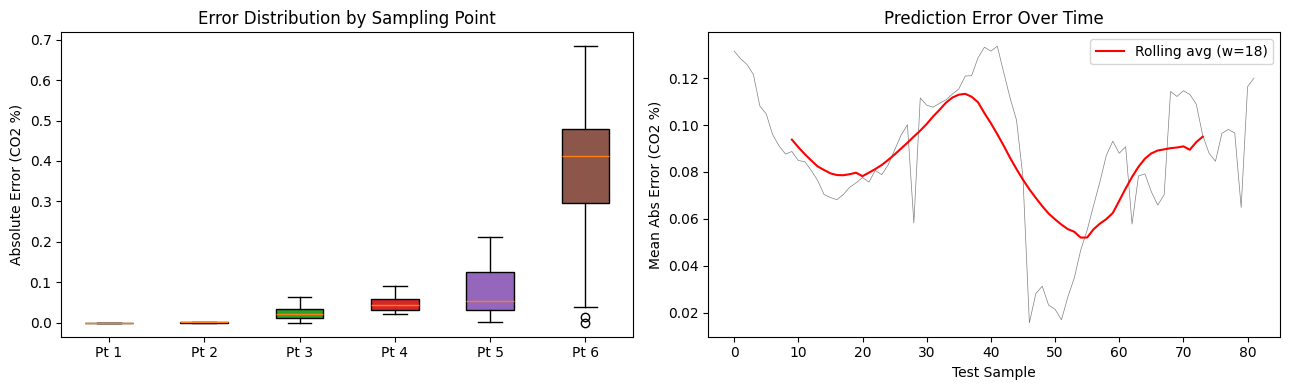

In [86]:
# Error distribution per sampling point
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Box plot
ax = axes[0]
bp = ax.boxplot([errors[:, p] for p in range(6)],
                labels=[f'Pt {p+1}' for p in range(6)],
                patch_artist=True, showfliers=True)
for i, patch in enumerate(bp['boxes']):
    patch.set_facecolor(colors[i+1])
ax.set_ylabel('Absolute Error (CO2 %)')
ax.set_title('Error Distribution by Sampling Point')

# Error over time
ax = axes[1]
mean_error_over_time = errors.mean(axis=1)  # (n,)
ax.plot(mean_error_over_time, 'k-', linewidth=0.5, alpha=0.5)

# Rolling average
window = 18
rolling = pd.Series(mean_error_over_time).rolling(window, center=True).mean()
ax.plot(rolling, 'r-', linewidth=1.5, label=f'Rolling avg (w={window})')
ax.set_xlabel('Test Sample')
ax.set_ylabel('Mean Abs Error (CO2 %)')
ax.set_title('Prediction Error Over Time')
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'error_analysis.png'), dpi=150)
plt.show()

## 6. Comparison with Original Project Results

Compare CO2 Transformer against results from the published paper:

1. DAE-LSTM
2. Kinetic model
3. SSAE
4. Fused
